In [252]:
from igraph import Graph
import sqlalchemy as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

from collections import Counter, OrderedDict
from itertools import chain

In [238]:
plt.style.use('ggplot')

# Create connection to the database

In [102]:
engine = sql.create_engine('sqlite:///database.db', encoding='utf8')
conn = engine.connect()

metadata = sql.MetaData()

In [104]:
phone_list = sql.Table('PhoneLabel',
                       metadata,
                       autoload=True,
                       autoload_with=engine)
edges_list = sql.Table('SourceTargetTable',
                       metadata,
                       autoload=True,
                       autoload_with=engine)

# Query from PhoneLabel table to get vertices

In [4]:
query = sql.select([phone_list])

users_list = pd.DataFrame(conn.execute(query).fetchall(),
                          columns=['Id', 'Name', 'Type', 'IsMember'])

In [5]:
name = users_list['Name'].values.tolist()
types = users_list['Type'].values.tolist()
is_member = users_list['IsMember'].values.tolist()

# Query from SourceEdgeTable to get edges

In [106]:
query = sql.select([
    edges_list.columns.Source, edges_list.columns.Target,
    sql.func.sum(edges_list.columns.Duration)
]).where(edges_list.columns.EdgeType == 1).group_by(edges_list.columns.Source,
                                                    edges_list.columns.Target)

edges_df = pd.DataFrame(conn.execute(query).fetchall(),
                        columns=['Source', 'Target', 'Duration'])

In [108]:
edges = pd.DataFrame(edges_df, columns=['Source', 'Target']).values.tolist()
duration = edges_df['Duration'].values.tolist()

In [111]:
edges = list(map(tuple, edges))

In [9]:
conn.close()

# Graph Construction

In [180]:
g = Graph(directed=True)

g.add_vertices(name, attributes={'Type': types, 'IsMember': is_member})
g.add_edges(edges, attributes={'weights': duration})

In [184]:
zero_edges = [e.index for e in g.es if e['weights']==0]
g.delete_edges(zero_edges)

In [181]:
vs_deg_0 = [v.index for v in g.vs if v.degree() == 0]
g.delete_vertices(vs_deg_0)

# Set Weights

In [182]:
query = sql.select([
    edges_list.columns.Source,
    sql.func.sum(edges_list.columns.Duration)
]).where(edges_list.columns.EdgeType == 1).group_by(edges_list.columns.Source)

total_duration_users = conn.execute(query).fetchall()

In [155]:
total_duration_users = dict(total_duration_users)

In [185]:
for e in g.es:
    source = g.vs[e.source]['name']
    e['weights'] = e['weights']/total_duration_users[source]

In [241]:
# Save the Graph to CallRank.graphml

g.write_graphml('summary/CallRank.graphml')

# Results

In [157]:
trusted_nodes = [v.index for v in g.vs if v['Type'] == 0]

advert_spam = [v.index for v in g.vs if v['Type'] == 1]
loan_spam = [v.index for v in g.vs if v['Type'] == 2]
debt_spam = [v.index for v in g.vs if v['Type'] == 3]
cheat_spam = [v.index for v in g.vs if v['Type'] == 4]
estate_spam = [v.index for v in g.vs if v['Type'] == 5]
others_spam = [v.index for v in g.vs if v['Type'] == 6]

In [267]:
trusted_nodes_rank = [g.pagerank(trusted_nodes, weights=g.es['weights'])][0]

advert_spam_rank = [g.personalized_pagerank(advert_spam, weights=g.es['weights'])][0]
loan_spam_rank = [g.personalized_pagerank(loan_spam, weights=g.es['weights'])][0]
debt_spam_rank = [g.personalized_pagerank(debt_spam, weights=g.es['weights'])][0]
cheat_spam_rank = [g.personalized_pagerank(cheat_spam, weights=g.es['weights'])][0]
estate_spam_rank = [g.personalized_pagerank(cheat_spam, weights=g.es['weights'])][0]
others_spam_rank = [g.personalized_pagerank(others_spam, weights=g.es['weights'])][0]

In [283]:
def scale_up(sample, scale_factor = 1e5):
    return list(map(lambda x: x*scale_factor, sample))

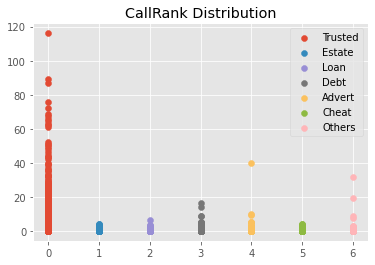

In [284]:
legend = ['Trusted', 'Estate', 'Loan', 'Debt', 'Advert', 'Cheat', 'Others']
plt.scatter([0 for _ in range(len(trusted_nodes_rank))], scale_up(trusted_nodes_rank))
plt.scatter([1 for _ in range(len(estate_spam_rank))], scale_up(estate_spam_rank))
plt.scatter([2 for _ in range(len(loan_spam_rank))], scale_up(loan_spam_rank))
plt.scatter([3 for _ in range(len(debt_spam_rank))], scale_up(debt_spam_rank))
plt.scatter([4 for _ in range(len(advert_spam_rank))], scale_up(advert_spam_rank))
plt.scatter([5 for _ in range(len(cheat_spam_rank))], scale_up(cheat_spam_rank))
plt.scatter([6 for _ in range(len(others_spam_rank))], scale_up(others_spam_rank))
plt.legend(legend)
plt.title('CallRank Distribution')
plt.savefig('summary/CallRank Distribution.png', dpi=600)

In [281]:
def get_confidence_interval(sample, alpha=0.95):
    return np.around(ss.poisson.interval(alpha, np.mean(sample), np.var(sample, ddof=1)), 4)

In [285]:
alpha = 0.95

print("Trusted Users: ", get_confidence_interval(scale_up(trusted_nodes_rank), alpha))
print("Estate Spam User: ", get_confidence_interval(scale_up(estate_spam_rank), alpha))
print("Debt Spam User: ", get_confidence_interval(scale_up(debt_spam_rank), alpha))
print("Loan Spam User: ", get_confidence_interval(scale_up(loan_spam_rank), alpha))
print("Cheat Spam User: ", get_confidence_interval(scale_up(cheat_spam_rank), alpha))
print("Advert Spam User: ", get_confidence_interval(scale_up(advert_spam_rank), alpha))
print("Others Spam User: ", get_confidence_interval(scale_up(others_spam_rank), alpha))

Trusted Users:  [13.5124 16.5124]
Estate Spam User:  [0.1318 2.1318]
Debt Spam User:  [0.6488 2.6488]
Loan Spam User:  [0.1554 2.1554]
Cheat Spam User:  [0.1318 2.1318]
Advert Spam User:  [1.6086 3.6086]
Others Spam User:  [3.5711 5.5711]


# Unlabeled Users

In [271]:
unlabeled_user = [v.index for v in g.vs if v['Type'] == -1]
unlabeled_user_rank = [g.personalized_pagerank(unlabeled_user, weights=g.es['weights'])][0]
get_confidence_interval(scale_up(unlabeled_user_rank), 0.95)

(0.07840370203149138, 2.0784037020314914)

In [177]:
len(g.es)

278854

(array([4.70941145e-01, 1.57046646e-02, 9.82038521e-03, 5.92403804e-03,
        3.77707123e-03, 2.70358783e-03, 1.43131120e-03, 1.66986307e-03,
        1.23251798e-03, 6.75896958e-04, 8.34931536e-04, 2.78310512e-04,
        4.37345090e-04, 4.77103735e-04, 2.78310512e-04, 2.38551867e-04,
        1.19275934e-04, 1.59034578e-04, 7.95172892e-05, 1.59034578e-04,
        3.97586446e-05, 7.95172892e-05, 3.97586446e-05, 1.19275934e-04,
        0.00000000e+00, 3.97586446e-05, 1.19275934e-04, 3.97586446e-05,
        3.97586446e-05, 3.97586446e-05, 7.95172892e-05, 3.97586446e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.97586446e-05, 7.95172892e-05, 3.97586446e-05, 3.97586446e-05,
        3.97586446e-05, 3.97586446e-05, 0.00000000e+00, 3.97586446e-05,
        0.00000000e+00, 3.97586446e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.97586446e-05, 3.97586446e-05, 0.00000000e+00, 0.000000

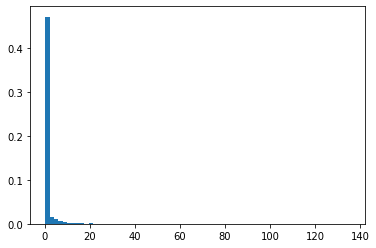

In [232]:
plt.hist(scale_up(trusted_nodes_rank), bins=70, density=True)

In [259]:
vs_deg = [v.degree(mode = "OUT") for v in g.vs]
total_out = sum(vs_deg)

deg_dist = OrderedDict(sorted(Counter(vs_deg).items()))

x_deg = list(chain.from_iterable(deg_dist.items()))[::2]
y_deg = list(chain.from_iterable(deg_dist.items()))[1::2]

In [260]:
y_deg = list(map(lambda y: y/total_out, y_deg))

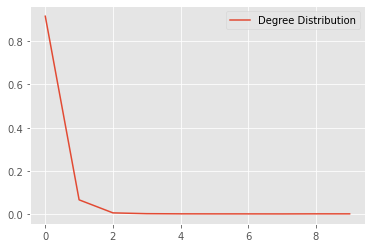

In [262]:
plt.plot(x_deg[:10], y_deg[:10])
plt.legend(['Degree Distribution'])
plt.savefig('summary/Degree Distribution.png', dpi = 600)